[![在 Colab 中打开](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/edit-state-human-feedback.ipynb) [![在 LangChain Academy 中打开](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239520-lesson-3-editing-state-and-human-feedback)


# 编辑图状态

## 回顾

我们讨论了 human-in-the-loop 的动机：

(1) `Approval`（批准）- 我们可以中断智能体，向用户展示状态，并允许用户接受某个动作

(2) `Debugging`（调试）- 我们可以回滚图，以复现或规避问题

(3) `Editing`（编辑）- 你可以修改状态

我们已经展示了断点如何支持用户批准，但当图被中断后，我们还不知道如何修改图状态！

## 目标

现在，我们来演示如何直接编辑图状态，并引入人类反馈。


In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [ ]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


# _set_env("OPENAI_API_KEY")
_set_env("DASHSCOPE_API_KEY")

## 编辑状态 

之前我们介绍了断点。

我们用它们来中断图，并在执行下一个节点前等待用户批准。

但断点同样是[修改图状态的好时机](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/edit-graph-state/)。

让我们给智能体设置一个在 `assistant` 节点之前的断点。


In [3]:
# from langchain_openai import ChatOpenAI
from langchain_community.chat_models import ChatTongyi


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [add, multiply, divide]
# llm = ChatOpenAI(model="gpt-4o")
llm = ChatTongyi(model="qwen-plus")
llm_with_tools = llm.bind_tools(tools)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


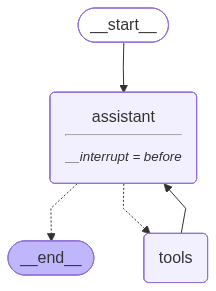

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(
    content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
)


# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

运行看看！

我们可以看到图在聊天模型响应之前就被中断了。


In [5]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [6]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='41beeaaa-6ddb-4e9a-90bf-f1c352870c44')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f09aebd-c551-698c-8000-58a863232d27'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-09-26T15:17:05.304197+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f09aebd-c54e-634a-bfff-85bd485d69fa'}}, tasks=(PregelTask(id='f1bfd28e-8fc9-8c66-8dbc-ba6397d0e91a', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

现在，我们可以直接应用状态更新。

请记住，对 `messages` 键的更新会使用 `add_messages` 归约器：
 
* 如果我们想覆盖已有消息，可以提供该消息的 `id`。
* 如果只是想向消息列表追加内容，就像下面展示的那样，可以传入没有 `id` 的消息。


In [ ]:
############### different from last lesson #####################
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]},
)
############### different from last lesson #####################

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09aebe-a6ab-67fc-8001-3b4605cec415'}}

来看一下结果。

我们调用了 `update_state` 添加了一条新消息。

`add_messages` 归约器把它追加到了我们的状态键 `messages` 上。


In [8]:
new_state = graph.get_state(thread).values
for m in new_state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 3!


现在，让我们通过传入 `None` 让智能体从当前状态继续执行。

会先发出当前状态，然后继续运行剩余的节点。


In [9]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_c2f13dee07c042b8b2b329)
 Call ID: call_c2f13dee07c042b8b2b329
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


现在我们回到了带有 `breakpoint` 的 `assistant` 节点。

我们同样可以传入 `None` 让它继续。


In [10]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The result of multiplying 3 and 3 is 9.


### 在 Studio 中编辑图状态

**⚠️ 免责声明**

自从录制这些视频以来，我们已经更新了 Studio，使其可以在本地运行并在浏览器中打开。现在推荐的方式是以这种形式运行 Studio（而不是像视频中展示的桌面应用）。关于本地开发服务器请查看[这里](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server)的文档，关于本地 Studio 的运行方式请查看[这里](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)。在本模块的 `/studio` 目录中，在终端运行以下命令即可启动本地开发服务器：

```
langgraph dev
```

你应该会看到如下输出：
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

在浏览器中访问 Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`。

LangGraph API [支持编辑图状态](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation)。


In [ ]:
if "google.colab" in str(get_ipython()):
    raise Exception(
        "Unfortunately LangGraph Studio is currently not supported on Google Colab"
    )

In [11]:
# This is the URL of the local development server
from langgraph_sdk import get_client

client = get_client(url="http://127.0.0.1:2024")

我们的智能体定义在 `studio/agent.py` 中。

如果你查看代码会发现它**没有**断点！
 
当然，我们可以在 `agent.py` 里加上断点，但 API 的一个优点是可以直接传入断点。

这里我们传入的是 `interrupt_before=["assistant"]`。


In [12]:
initial_input = {"messages": "Multiply 2 and 3"}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get("messages", [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'a7c68b57-40bd-4f5b-8486-9a00ee7ca684', 'example': False}
--------------------------------------------------


我们可以获取当前状态。


In [13]:
current_state = await client.threads.get_state(thread["thread_id"])
current_state

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'a7c68b57-40bd-4f5b-8486-9a00ee7ca684',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'c4db11cb-c0df-5f91-56af-fdeaa60b8a0a',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'host': '127.0.0.1:2024',
  'accept-encoding': 'gzip, deflate, zstd',
  'connection': 'keep-alive',
  'user-agent': 'langgraph-sdk-py/0.2.9',
  'content-length': '170',
  'content-type': 'application/json',
  'accept': 'text/event-stream',
  'cache-control': 'no-store',
  'x-request-id': '7762ae4d-a5b0-4e35-a8f3-559f956525c8',
  'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions': [],
  'langgraph_request_id': '7762ae4d-a5b0-4e35-a8f3-559f956525c8',
  'graph_id':

我们可以查看状态中最后一条消息。


In [14]:
last_message = current_state["values"]["messages"][-1]
last_message

{'content': 'Multiply 2 and 3',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': 'a7c68b57-40bd-4f5b-8486-9a00ee7ca684',
 'example': False}

我们可以修改它！


In [15]:
last_message["content"] = "No, actually multiply 3 and 3!"
last_message

{'content': 'No, actually multiply 3 and 3!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': 'a7c68b57-40bd-4f5b-8486-9a00ee7ca684',
 'example': False}

In [16]:
last_message

{'content': 'No, actually multiply 3 and 3!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': 'a7c68b57-40bd-4f5b-8486-9a00ee7ca684',
 'example': False}

记住，正如之前所说，对 `messages` 键的更新会使用同一个 `add_messages` 归约器。

如果我们想覆盖已有消息，就需要提供消息 `id`。

这里我们就是这么做的，如上所示，我们只修改了消息的 `content`。


In [ ]:
############### different from last lesson #####################
await client.threads.update_state(thread["thread_id"], {"messages": last_message})
############### different from last lesson #####################

{'checkpoint': {'thread_id': 'd93f1708-ba60-4c0e-9941-7075c14cc807',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09aec2-c0f5-6a1e-8001-09fab30f3c5a'},
 'configurable': {'thread_id': 'd93f1708-ba60-4c0e-9941-7075c14cc807',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09aec2-c0f5-6a1e-8001-09fab30f3c5a'},
 'checkpoint_id': '1f09aec2-c0f5-6a1e-8001-09fab30f3c5a'}

现在，我们通过传入 `None` 继续执行。


In [18]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get("messages", [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'No, actually multiply 3 and 3!', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'a7c68b57-40bd-4f5b-8486-9a00ee7ca684', 'example': False}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_cfad43bc76914f8ba18fe2', 'type': 'function', 'function': {'name': 'multiply', 'arguments': '{"a": 3, "b": 3}'}}]}, 'response_metadata': {'model_name': 'qwen-plus', 'finish_reason': 'tool_calls', 'request_id': '61d6230f-d782-4112-ae2b-21907fa0ce35', 'token_usage': {'input_tokens': 354, 'output_tokens': 24, 'total_tokens': 378, 'prompt_tokens_details': {'cached_tokens': 0}}}, 'type': 'ai', 'name': None, 'id': 'run--8af0dfcf-04a1-49af-b76f-b1fdfe7b594d-0', 'example': False, 'tool_calls': [{'name': 'multiply'

如预期所示，我们得到了工具调用的结果 `9`。


In [19]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get("messages", [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '9', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '81a1b78a-c3a1-4e63-9f00-5f4214459e6b', 'tool_call_id': 'call_cfad43bc76914f8ba18fe2', 'artifact': None, 'status': 'success'}
--------------------------------------------------
Receiving new event of type: values...
{'content': 'The result of multiplying 3 and 3 is 9.', 'additional_kwargs': {}, 'response_metadata': {'model_name': 'qwen-plus', 'finish_reason': 'stop', 'request_id': '5fd66424-1e7b-4154-8647-625b6e5964c3', 'token_usage': {'input_tokens': 393, 'output_tokens': 13, 'total_tokens': 406, 'prompt_tokens_details': {'cached_tokens': 0}}}, 'type': 'ai', 'name': None, 'id': 'run--a68d52cf-a1b4-4b32-85d4-a2c61fa74ce3-0', 'example': False, 'tool_calls': [], 'invalid_tool_calls': [], 'usage_metadata': None}
-----------------------------------------

## 等待用户输入

现在已经明确，我们可以在断点之后编辑智能体状态。

那么如果我们想让人类反馈来执行这个状态更新呢？

我们会在智能体中添加一个[用于收集人类反馈的占位节点](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/#setup)。

`human_feedback` 节点允许用户直接向状态添加反馈。
 
我们通过 `interrupt_before` 为 `human_feedback` 节点设置断点。

我们还设置了一个检查点，在到达这个节点之前保存图的状态。


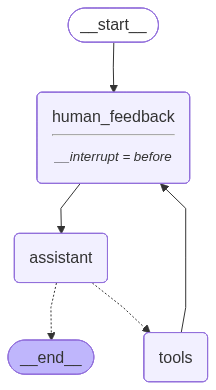

In [20]:
# System message
sys_msg = SystemMessage(
    content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
)


# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass


# Assistant node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

我们将获取用户的反馈。

我们和之前一样，使用 `.update_state` 把获得的人类回答更新到图状态中。

我们使用 `as_node="human_feedback"` 参数，把这次状态更新标记为来自 `human_feedback` 节点。


In [ ]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

# Get user input
user_input = input("Tell me how you want to update the state: ")

############### different from this lesson above #####################
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")
############### different from this lesson above #####################

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

Actually, multiply 4 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_f0cfebb8f7124a339d345e)
 Call ID: call_f0cfebb8f7124a339d345e
  Args:
    a: 4
    b: 3
================================= Tool Message =================================
Name: multiply

12


In [22]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

12
================================== Ai Message ==================================

The result of multiplying 4 and 3 is 12.
